# GRU training

5 games data will be used for training model  
3 games for training, 1 game for validation and the last for test

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils as torch_utils
import pandas as pd
from torch.utils.data import DataLoader,Dataset
import h5py
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

os.environ["CUDA_VISIBLE_DEVICES"]="1"
!nvidia-smi

Mon Jun 15 10:37:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.51                 Driver Version: 396.51                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0  On |                  N/A |
| 45%   76C    P2   169W / 250W |   7947MiB / 11177MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   41C    P8    16W / 250W |     12MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Construct custom dataloader

In [4]:
class Customdataset(Dataset):
    def __init__(self,second,dataset_type,transform=None):
        '''
        Call stored dataset
        
        Params
        second: Ellapsed second from the beginning of events 
        dataset_type: Type of dataset, trainset, validset, and testset
        '''
        filepath='./data/game_data/seconds_'+str(second)+'/'+dataset_type+'.hdf5'
        dataset = h5py.File(filepath,'r')
        
        # Transforms
        self.transform = transform
        self.x_data=dataset['image']
        self.y_data=dataset['label']
        self.timepoint = 1+ 2 * second 

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self,idx):
        
        # Convert x and y data to torch flaot tensor
        x = torch.FloatTensor(self.x_data[idx])
        x = x.view(self.timepoint,-1)
        if self.y_data[idx] ==0:
            y = [1,0]
        else:
            y = [0,1]
        y = torch.FloatTensor(y)
        
        return x,y

## Modeling GRU

In [5]:
class GRU(nn.Module):
    def __init__(self, input_size,hidden_size, num_layers, output_size):
        super(GRU,self).__init__()
        
        self.input_size =  input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size,hidden_size,num_layers,batch_first=True,dropout=0.2)
        self.fc = nn.Linear(hidden_size,output_size)
        self.relu = nn.ReLU()
        
    def forward(self,inputs,hidden):        
        hidden = hidden.reshape(self.num_layers,batch_size,-1)        
        output, hidden = self.gru(inputs,hidden)
        output = self.relu(output)
        output = self.fc(output)
        output = output[:,-1]
#         output = torch.sigmoid(output)
        
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,batch_size,self.hidden_size)

In [5]:
loss_second_dict={}
vloss_second_dict={}
model_second={}
for second in range(1,11):
    print('Second: ',second, 'is now training')
    timepoint = 1+second*2
    batch_size =1
    dataset_type = 'trainset'

    trainset = Customdataset(second=second,dataset_type=dataset_type)
    train_loader = DataLoader(trainset, batch_size=batch_size)
    dataset_type = 'validset'
    validset = Customdataset(second=second,dataset_type=dataset_type)
    valid_loader = DataLoader(validset, batch_size=batch_size)

    n_hidden = 1000
    lr = 0.001
    epochs = 201

    model = GRU(5824, n_hidden,1,2)
    model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    
    loss_graph={}
    vloss_graph={}
    for epoch in range(epochs):
        hidden = model.initHidden()
        hidden = hidden.cuda()
        running_loss=0
        for x,y in train_loader:
            x = x.cuda()
            y= y.cuda()
            x = x.reshape(batch_size,timepoint,-1)
            optimizer.zero_grad()
            output,hidden = model(x,hidden)
            loss = criterion(output, y)
            running_loss += loss
            
        running_loss.backward()
        optimizer.step()
        loss_graph[epoch]= running_loss.item()
        
        if epoch%10 ==0:
            with torch.no_grad():
                val_loss=0.0
                for val_x,val_y in valid_loader:
                    val_x = val_x.cuda()
                    val_y = val_y.cuda()
                    val_output,_ = model(val_x,hidden)
                    v_loss = criterion(val_output,val_y)
                    val_loss +=v_loss
            vloss_graph[epoch]=val_loss.item()
        
        
        if epoch %50 ==0:
            print("epoch: {}, loss: {:.5f}, v_loss: {:.5f}".format(epoch, running_loss.data,val_loss.data))
    loss_second_dict[second]= loss_graph
    vloss_second_dict[second]= vloss_graph
    model_second[second] = model
    
    #Save model
    save_path = './data/game_data/GRU_second_'+str(second)+'.pth'
    torch.save(model.state_dict(),save_path)


Second:  1 is now training


/home/suhwan/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


epoch: 0, loss: 347.43915, v_loss: 113.56865
epoch: 50, loss: 330.51596, v_loss: 112.98218
epoch: 100, loss: 330.36481, v_loss: 112.99229
epoch: 150, loss: 330.18927, v_loss: 113.01909
epoch: 200, loss: 330.00153, v_loss: 113.04726
Second:  2 is now training
epoch: 0, loss: 345.02539, v_loss: 112.05447
epoch: 50, loss: 330.97110, v_loss: 111.17309
epoch: 100, loss: 330.89175, v_loss: 111.18024
epoch: 150, loss: 330.81693, v_loss: 111.19785
epoch: 200, loss: 330.74490, v_loss: 111.21615
Second:  3 is now training
epoch: 0, loss: 366.40286, v_loss: 110.60381
epoch: 50, loss: 326.35721, v_loss: 111.16697
epoch: 100, loss: 326.33798, v_loss: 111.09310
epoch: 150, loss: 326.33566, v_loss: 111.08749
epoch: 200, loss: 326.33429, v_loss: 111.08752
Second:  4 is now training
epoch: 0, loss: 332.89944, v_loss: 107.57809
epoch: 50, loss: 326.49606, v_loss: 107.90147
epoch: 100, loss: 326.45758, v_loss: 107.99621
epoch: 150, loss: 326.43063, v_loss: 108.00408
epoch: 200, loss: 326.40012, v_loss: 1

In [ ]:
pd.DataFrame(vloss_second_dict).to_csv('./data/GRU/vloss_second_dict.csv')
pd.DataFrame(loss_second_dict).to_csv('./data/GRU/loss_second_dict.csv')

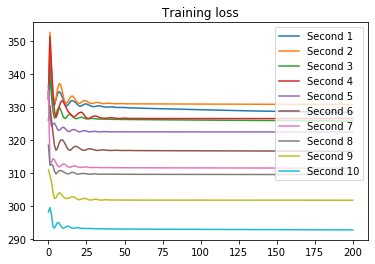

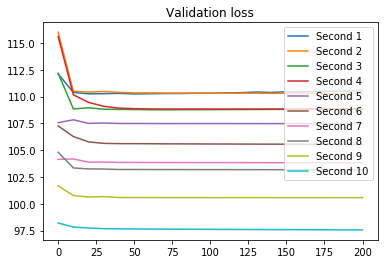

In [40]:
vloss_df = pd.read_csv('./data/GRU/vloss_second_dict.csv')
loss_df = pd.read_csv('./data/GRU/loss_second_dict.csv')
loss_df = loss_df.drop(columns=['Unnamed: 0'],axis=1)
vloss_df = vloss_df.rename(columns={'Unnamed: 0':'Index'})

plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'1']),label='Second 1')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'2']),label='Second 2')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'3']),label='Second 3')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'4']),label='Second 4')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'5']),label='Second 5')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'6']),label='Second 6')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'7']),label='Second 7')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'8']),label='Second 8')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'9']),label='Second 9')
plt.plot(list(loss_df.index.values),list(loss_df.loc[:,'10']),label='Second 10')
plt.title('Training loss')
plt.legend()
plt.show()
plt.cla()
plt.clf()
vloss_index= list(vloss_df['Index'])
vloss_df = vloss_df/3
plt.plot(vloss_index,list(vloss_df.loc[:,'1']),label='Second 1')
plt.plot(vloss_index,list(vloss_df.loc[:,'2']),label='Second 2')
plt.plot(vloss_index,list(vloss_df.loc[:,'3']),label='Second 3')
plt.plot(vloss_index,list(vloss_df.loc[:,'4']),label='Second 4')
plt.plot(vloss_index,list(vloss_df.loc[:,'5']),label='Second 5')
plt.plot(vloss_index,list(vloss_df.loc[:,'6']),label='Second 6')
plt.plot(vloss_index,list(vloss_df.loc[:,'7']),label='Second 7')
plt.plot(vloss_index,list(vloss_df.loc[:,'8']),label='Second 8')
plt.plot(vloss_index,list(vloss_df.loc[:,'9']),label='Second 9')
plt.plot(vloss_index,list(vloss_df.loc[:,'10']),label='Second 10')
plt.title('Validation loss')
plt.legend(loc='upper right')
plt.show()


In [22]:
Accuracy_dict={}
for second in range(1,11):
    model= GRU(5824, n_hidden,1,2).cuda()
    model.load_state_dict(torch.load("./data/game_data/GRU_second_"+str(second)+'.pth'))

    hidden = model.initHidden().cuda()
    dataset_type ='testset'
    testset = Customdataset(second=second,dataset_type=dataset_type)
    test_loader = DataLoader(testset, batch_size=batch_size)
    overall =0
    acc_count =0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()   
            y,hidden = model(inputs,hidden)
            y = torch.argmax(y.data)
            target =torch.argmax(targets.data[0])       

            if y ==target:
                acc_count +=1
            overall +=1
    print('Second:',second,'Accuracy: ', acc_count*100/overall,'%')
    Accuracy_dict[second] = acc_count*100/overall




/home/suhwan/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Second: 1 Accuracy:  56.79012345679013 %
Second: 2 Accuracy:  62.11180124223603 %
Second: 3 Accuracy:  55.625 %
Second: 4 Accuracy:  57.861635220125784 %
Second: 5 Accuracy:  50.63291139240506 %
Second: 6 Accuracy:  50.64102564102564 %
Second: 7 Accuracy:  54.60526315789474 %
Second: 8 Accuracy:  61.58940397350993 %
Second: 9 Accuracy:  54.054054054054056 %
Second: 10 Accuracy:  52.44755244755245 %


[Text(0, 0, '50.00%'),
 Text(0, 0, '52.00%'),
 Text(0, 0, '54.00%'),
 Text(0, 0, '56.00%'),
 Text(0, 0, '58.00%'),
 Text(0, 0, '60.00%'),
 Text(0, 0, '62.00%'),
 Text(0, 0, '64.00%')]

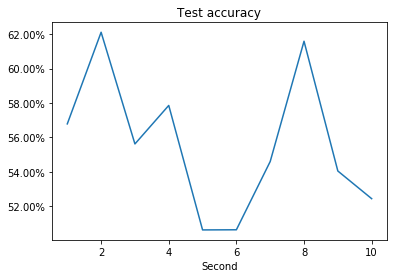

In [15]:
fig = plt.figure()
ax = fig.subplots()
ax.plot(list(Accuracy_dict.keys()),list(Accuracy_dict.values()))
ax.set_title('GRU Test accuracy')
ax.set_xlabel('Second')
y_value = ['{:,.2f}'.format(x)+'%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)

## Number of model parameters

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params/1024)

20000.001953125
